## Question 3:
In the third and last part, we are interested to see if we can create a model that accurately predicts whether a new customer would be interested in a Vehicle Insurance.

To answer this, let's first read in all necessary libraries, the train data and test data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

%matplotlib inline

## Gather

In [2]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Assess

Let's get an overview of the data. First we look at the type of the data. Then we check if there are any missing values.

In [3]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [4]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Let's now look for imbalances in the training data. An imbalance exists when one training class is underrepresented/overrepresented. This does not allow the model to learn features and successfully predict the underrepresented classes.

In [5]:
df['Response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: Response, dtype: float64

#### We see that 88% of the class is Response=0, while only 12% is Response=1. To deal with this we will test various models and approaches:
1. First, we test a LogisticRegression model with the imbalanced data.
2. Then, we test a RandomForestClassifier model with the imbalanced data. RandomForestClassifier models sometimes deal better with imbalanced data.
3. Finally, we resample the imbalanced variable (Response=1) and test a RandomForestClassifier model.

## Data preprocessing

We start with removing rows with NaNs in the Response column (here there aren't any NaNs)

In [6]:
# 1. Drop NaNs in 'Response'
df = df.dropna(subset=['Response'], axis=0)

We then split our training set to training data and training labels. We drop the 'id' column from both train and test data.

In [7]:
# 2. split to training data and labels

# Create X with only feature columns
X = df.drop(['Response','id'], axis=1)
# Create y with Response column
y = df['Response'] 
# Drop 'id' column also from df_test
df_test = df_test.drop(['id'], axis=1)

The training and test data have variables with types: object, int64 and float64. However the categorical variables are not only the ones of dtype=object, but also some of types int64 and float64. To deal with thosse, we will convert all categorical variables to dtype=object and create dummy columns.

In [8]:
# 3. Convert all categorical variables to dtype=object 

X = X.astype({'Driving_License': object, 'Region_Code': object, 'Previously_Insured': object, 'Policy_Sales_Channel': object})
df_test = df_test.astype({'Driving_License': object, 'Region_Code': object, 'Previously_Insured': object, 'Policy_Sales_Channel': object})

cat_vars2 = X.select_dtypes(include=['object']).columns

We create a function that will be used to create dummy columns for the categorical variables

In [9]:
def create_dummy(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables to dummy
    cat_cols - list of strings associated with the names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. dummy columns for each of the categorical columns in cat_cols
            3. if dummy_na is True - it also contains dummy columns for the NaN values
            4. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    df = pd.concat([df.select_dtypes(exclude='object'), pd.get_dummies(df[cat_cols], prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
    return df

In [10]:
# 4. Create dummy columns

X = create_dummy(X, cat_vars2, dummy_na=True)
df_test = create_dummy(df_test, cat_vars2, dummy_na=True) 

# Check if there are differences in the dummy column names of the two dataframes.
# If a dataframe misses a dummy column, then add it and fill it with zeros.
for col in set(X.columns).symmetric_difference(set(df_test.columns)): 
    if col in X.columns:
        df_test[col]=0
    else:
        X[col]=0

After dummying the categorical columns we can fill any NaNs in the remaining numerical variables using mode(). We choose the mode to fill in NaNs (for Age, Annual_Premium, Vintage) because both Annual_Premium and Vintage follow a symmetric distribution, whereas the Age variable has a right-skewed distribution (as seen in notebook for question 1). Therefore, for those variables the mode would fill in NaNs more closely to the original values. 

In [11]:
# 5. Fill any numerical NaNs with mode()

fill_mode = lambda col: col.fillna(col.mode())
X = X.apply(fill_mode, axis=0)
df_test = df_test.apply(fill_mode, axis=0)

Let's now split the data into training and validation sets.

In [12]:
# 6. Split into train/validation/test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.20, random_state=42)
X_test = df_test.copy()

# Modeling

### 1. Testing a LogisticRegression model (with imbalanced data)

In [13]:
# 7. Instantiate model
model1 = LogisticRegression(solver='liblinear',random_state=42) # For binary classification

In [14]:
# 8. Fit to model
model1.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [15]:
# 9. Predict using validation set
preds1 = model1.predict(X_val)
probs1 = model1.predict_proba(X_val)[:,1]

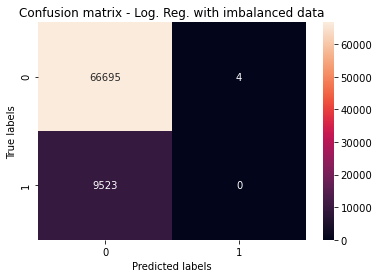

In [16]:
# 10. Confusion matrix
matrix1 = confusion_matrix(y_val, preds1)
ax = plt.subplot();
sns.heatmap(matrix1, annot=True, ax = ax, fmt='g');
ax.set_title('Confusion matrix - Log. Reg. with imbalanced data');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

From the confusion matrix we see that the model cannot predict any positive responses. That is due to the imbalance in the training labels for Response=1. Let's also see how our model scores. 

In [17]:
# 11. Score model predictions
score_acc1 = accuracy_score(y_val, preds1)
score_roc1 = roc_auc_score(y_val, preds1) # Suggested Kaggle metric
score_acc1, score_roc1

(0.8750098396788328, 0.49997001454294665)

The accuracy score is higher than the roc_auc score. However the roc_auc metric is more representative for the performance of our model. 

Let's now test how a RandomForestClassifier model works with our imbalanced data:

### 2. Testing a RandomForestClassifier model (with imbalanced data)

In [18]:
# 7. Instantiate model
model2 = RandomForestClassifier()

In [19]:
# 8. Fit to model
model2.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
# 9. Predict using validation set
preds2 = model2.predict(X_val)
probs2 = model2.predict_proba(X_val)[:,1]

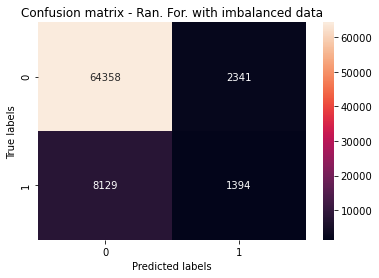

In [21]:
# 10. Confusion matrix
matrix2 = confusion_matrix(y_val, preds2)
ax = plt.subplot();
sns.heatmap(matrix2, annot=True, ax = ax, fmt='g');
ax.set_title('Confusion matrix - Ran. For. with imbalanced data');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

From the confusion matrix we see that the model now is a bit better with predicting positive responses. Let's also see how our model scores. 

In [22]:
# 11. Score model predictions
score_acc2 = accuracy_score(y_val, preds2)
score_roc2 = roc_auc_score(y_val, preds2) 
score_acc2, score_roc2

(0.8626380834929548, 0.5556422325133457)

The RandomForestClassifier gives a bit better scores with the imbalanced data.

Finally, Let's now test how a RandomForestClassifier model works with our balanced data:

### 3. Testing a RandomForestClassifier model (resampled imbalanced data using bootstrapping)

First we resample the imbalanced data using bootstrapping.

In [23]:
df0 = df[df['Response']==0]
df1 = df[df['Response']==1]
 
# Resample (replace=True:sample with replacement, n_samples:same as balanced class)
df1_boot = resample(df1, replace=True, n_samples=len(df0), random_state=42)
 
# Merge and check if data are balanced
df_res = pd.concat([df0, df1_boot])
df_res['Response'].value_counts(normalize=True)

1    0.5
0    0.5
Name: Response, dtype: float64

Then we repeat the data preprocessing steps on the new balanced data:

In [24]:
X_res = df_res.drop(['Response','id'], axis=1)
y_res = df_res['Response'] 

X_res = X_res.astype({'Driving_License': object, 'Region_Code': object, 'Previously_Insured': object, 'Policy_Sales_Channel': object})
X_res = create_dummy(X_res, cat_vars2, dummy_na=True)

for col in set(X_res.columns).symmetric_difference(set(df_test.columns)): 
    if col in X_res.columns:
        df_test[col]=0
    else:
        X_res[col]=0

        
X_res = X_res.apply(fill_mode, axis=0)
X_res_train, X_res_val, y_res_train, y_res_val = train_test_split(X_res, y_res, test_size=.20, random_state=42)


In [25]:
# 7. Instantiate model
model3 = RandomForestClassifier()

In [26]:
# 8. Fit to model
model3.fit(X_res_train, y_res_train)

RandomForestClassifier()

In [27]:
# 9. Predict using validation set
preds3 = model3.predict(X_res_val)
probs3 = model3.predict_proba(X_res_val)[:,1]

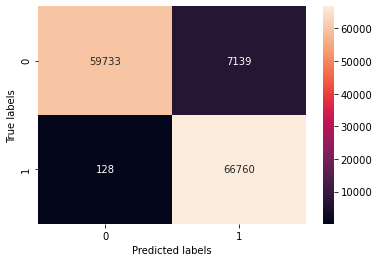

In [28]:
# 10. Confusion matrix
matrix3 = confusion_matrix(y_res_val, preds3)
ax = plt.subplot();
sns.heatmap(matrix3, annot=True, ax = ax, fmt='g');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

The confusion matrix now shows that the model now is much better with predicting positive responses. This is because our data are now balanced. Let's see how this model scores.

In [29]:
# 11. Score model predictions
score_acc3 = accuracy_score(y_res_val, preds3)
score_roc3 = roc_auc_score(y_res_val, preds3) 
score_acc3, score_roc3

(0.9456713516746411, 0.9456650811875456)

Both scores are now much better. Let's see what the ROC curve looks like:

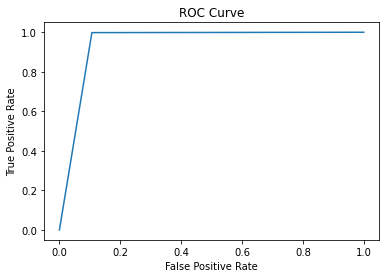

In [30]:
# ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_res_val, preds3)
plt.plot(false_positive_rate, true_positive_rate)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Let's look at the validation set, and the probabilities for a positive response based on our model. How close are they to actual responses?

In [31]:
comp = pd.DataFrame()
comp['Actual Response']=y_res_val
comp['Predicted probability for positive response']=probs3
comp.head(10)

,Actual Response,Predicted probability for positive response
265630,1,0.99
207847,1,1.00
32317,0,0.00
213261,1,0.89
65815,1,0.99
73037,0,0.00
107195,1,1.00
252945,0,0.09
122200,1,0.95
379991,0,0.00


As expected, the predicted probabilities for a positive response are very close to the actual responses.

 The model performs very well, so we can use it to predict unknown data.

### Predict on unknown test data

In [32]:
y_test_preds = model3.predict(X_test)
y_test_preds

array([0, 1, 0, ..., 0, 0, 0])

## Visualize

Now we are interested to see how the profiles of existing customers and their actual responses compare to the profiles of new customers and their predicted responses. 

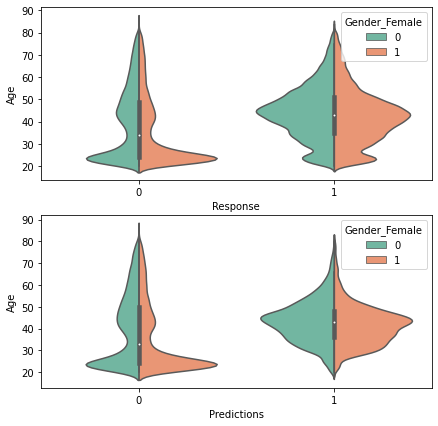

In [33]:
df_test['Predictions']=y_test_preds

df_train = X_res.copy()
df_train['Response'] = y_res.copy()


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,7))
sns.violinplot(ax=ax1, data=df_train, x='Response', y='Age', hue='Gender_Female', palette='Set2', split=True);
sns.violinplot(ax=ax2, data=df_test, x='Predictions', y='Age', hue='Gender_Female', palette='Set2', split=True);
#plt.savefig('preds2.png',dpi=400)


The plots show that the trends in the predicted customer behavior are similar to those we observed previously (see notebook for question 1).